# Pinball loss

In [1]:
from utilities.std_imports import *
from IPython import display
import sympy as sy
from utilities.tf_imports import *


$\large
L_{\tau} =
\begin{cases} 
      (y - z) \; \tau & if \quad z \le y \\
      (z - y) \; (1 - \tau) &  if \quad z > y \\
\end{cases}
$

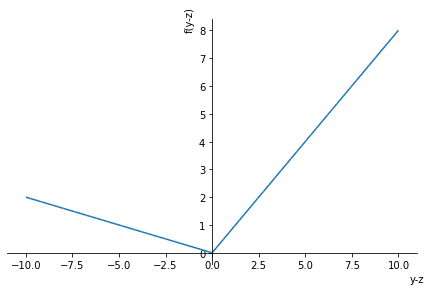

In [2]:
y_z = sy.symbols('y-z')
t = 0.2
pw = sy.Piecewise((-(y_z) * t, y_z<=0), ((y_z) * (1-t), y_z>0))
sy.plot(pw);

In [3]:
def pinball_loss(y, z, tau):
    if y>=z: return (y-z) * tau
    else: return (z-y)* (1-tau)

For $\tau = 0.5$ : it yields back the absolute value so equal penalizing errors    
For $\tau < 0.5$ : it penalizes overpredicting  
For $\tau > 0.5$ : it penalizes underpredicting

In [4]:
u05 = pinball_loss(80, 65, 0.05)
o05 = pinball_loss(80, 95, 0.05)
u50 = pinball_loss(80, 65, 0.50)
o50 = pinball_loss(80, 95, 0.50)
u95 = pinball_loss(80, 65, 0.95)
o95 = pinball_loss(80, 95, 0.95)

print('5%')
print('underpredicted : ', round(u05, 2))
print('overpredicted  : ', round(o05, 2))
print('50%')
print('underpredicted : ', round(u50, 2))
print('overpredicted  : ', round(o50, 2))
print('95%')
print('underpredicted : ', round(u95, 2))
print('overpredicted  : ', round(o95, 2))

5%
underpredicted :  0.75
overpredicted  :  14.25
50%
underpredicted :  7.5
overpredicted  :  7.5
95%
underpredicted :  14.25
overpredicted  :  0.75


### Forecasting application

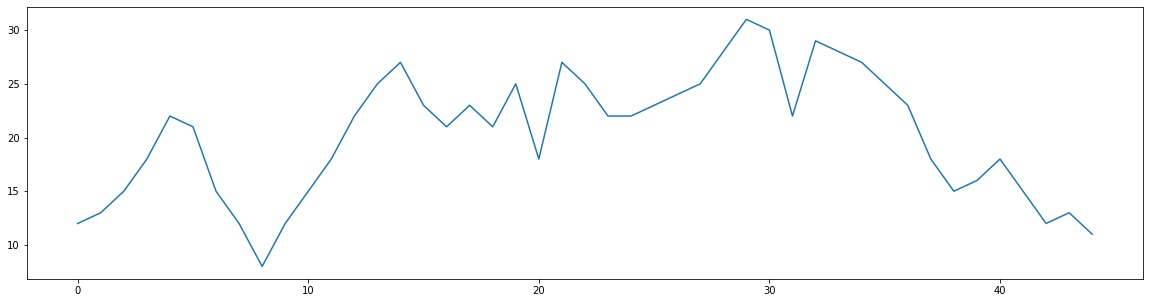

In [5]:
ts = [12, 13, 15, 18, 22, 21, 15, 12, 8,  12, 15, 18, 22, 25, 27, 23, 21, 23, 21, 25, 18, 27, 25, 22, 22, 23, 24, 25, 28, 31, 30, 22, 29, 28, 27, 25, 23, 18, 15, 16, 18, 15, 12, 13, 11]
ts = np.array(ts).astype(float)
plt.figure(figsize=[20,5])
plt.plot(ts);

In [6]:
tsGen = tkp.sequence.TimeseriesGenerator(ts, ts, length=6, batch_size=8)
tsGen[0]

(array([[12., 13., 15., 18., 22., 21.],
        [13., 15., 18., 22., 21., 15.],
        [15., 18., 22., 21., 15., 12.],
        [18., 22., 21., 15., 12.,  8.],
        [22., 21., 15., 12.,  8., 12.],
        [21., 15., 12.,  8., 12., 15.],
        [15., 12.,  8., 12., 15., 18.],
        [12.,  8., 12., 15., 18., 22.]]),
 array([15., 12.,  8., 12., 15., 18., 22., 25.]))

In [7]:
model = tkm.Sequential()
model.add(tkl.Dense(12, activation='relu', input_dim=6))
model.add(tkl.Dense(8, activation='relu', input_dim=6))
model.add(tkl.Dense(1))
model.compile(optimizer='sgd', loss=tfa.losses.PinballLoss(tau=0.8))
model.fit(tsGen, steps_per_epoch=1, epochs=200, verbose=0)

In [8]:
x_input = np.array([12, 13, 15, 18, 22, 21, 15, 12, 8,  12, 15, 18, 22, 25, 27, 23, 21, 23]).reshape((3, 6))
x_input
pred = model.predict(tsGen[0][0], verbose=0)

res = pd.DataFrame({'actual': tsGen[0][1], 'pred': np.round(pred.flatten(),1)})
res['diff'] = round(res['actual'] - res['pred'],1)
res

,actual,pred,diff
0,15.0,17.400000,-2.4
1,12.0,16.600000,-4.6
2,8.0,16.100000,-8.1
3,12.0,16.600000,-4.6
4,15.0,19.500000,-4.5
5,18.0,17.799999,0.2
6,22.0,17.600000,4.4
7,25.0,15.700000,9.3
